In [44]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('../../minisom/')))
reload(minisom)
from minisom import MiniSom

sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

sys.path.append(os.path.abspath(os.path.join('../')))
print(sys.path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

['/eos/home-n/nchernya/MLHEP/AnomalyDetection/Clustering/notebooks', '', '/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/itk', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Wed/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Wed/x86_64-centos7-gcc8-opt/lib', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Wed/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/itk', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib', '/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft-nightlies.cern.ch/lcg/latest/Python/3.8.6-9a92d/x86_64-centos7-gcc8-opt/li

In [2]:
process_name_dict = {0: 'WW_13TeV_50PU',
                    1: 'WZ_13TeV_50PU',
                    2: 'ZZ_13TeV_50PU',
                    3: 'qcd_13TeV_50PU',
                    4: 'ttbar_13TeV_50PU',
                    5: 'Zjets_13TeV_50PU',
                    6: 'gammajets_13TeV_50PU',
                    7: 'Wjets_13TeV_50PU',
                    30: 'Ato4l',
                    31: 'hChToTauNu',
                    32: 'hToTauTau',
                    33: 'LQ'
                    }
def inverse_dict_map(f):
    return f.__class__(map(reversed, f.items()))

In [2]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/inputs/clustering_inputs/'
TRAIN_NAME = 'background_with_kl.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 

num_non_zero_particles = np.sum(np.array(in_file['Particles_HLT'])[:,:,0]>0,axis=1)-1
print('max number of objects : ', np.max(num_non_zero_particles))
freq,counts = np.unique(num_non_zero_particles, return_counts=True)
freq_counts_dict = {}
for i in range(len(freq)):
    freq_counts_dict[freq[i]] = counts[i]
print('Max number of particles, and frequency :')
print(freq_counts_dict)
#in_file['Particles_HLT'].shape

zero_particles_mask = np.where(num_non_zero_particles==0)
freq_id,counts_id = np.unique(in_file['PID'][zero_particles_mask], return_counts=True)
freq_id_tot,counts_id_tot = np.unique(in_file['PID'], return_counts=True)
prop_id_named_dict,freq_counts_id_dict, freq_counts_id_tot_dict = {}, {},{}
for i in range(len(freq_id)):
    freq_counts_id_dict[freq_id[i]] = counts_id[i]
for i in range(len(freq_id_tot)):
    freq_counts_id_tot_dict[freq_id_tot[i]] = counts_id_tot[i]
for key in freq_counts_id_dict.keys():
    prop_id_named_dict[process_name_dict[key]] = np.round(freq_counts_id_dict[key]/freq_counts_id_tot_dict[key],3)
    
print('process IDs for events with 0 objects, and proportion of events with 0 objects for that ID')
print(freq_counts_id_dict)
print('process IDs for events with 0 objects, and proportion of events with 0 objects for that ID')
print(prop_id_named_dict)


max number of objects :  11
Max number of particles, and frequency :
{0: 13165, 1: 38644, 2: 62144, 3: 54543, 4: 28363, 5: 10118, 6: 3002, 7: 872, 8: 214, 9: 65, 10: 16, 11: 2}
process IDs for events with 0 objects, and proportion of events with 0 objects for that ID
{0: 2, 1: 1, 3: 5578, 4: 3, 5: 2665, 6: 1194, 7: 3722}
process IDs for events with 0 objects, and proportion of events with 0 objects for that ID
{'WW_13TeV_50PU': 0.007, 'WZ_13TeV_50PU': 0.011, 'qcd_13TeV_50PU': 0.26, 'ttbar_13TeV_50PU': 0.001, 'Zjets_13TeV_50PU': 0.072, 'gammajets_13TeV_50PU': 0.023, 'Wjets_13TeV_50PU': 0.039}


In [3]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/inputs/clustering_inputs/'
TRAIN_NAME = 'background_with_kl.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['Particles_HLT'])
file_dataset = file_dataset[:,:,[0,1,2,4]] #removing charge for now
truth_dataset = np.array(in_file['PID'])
particle_id = file_dataset[:,:,[3]]
for p_id in [2,3,4,5]:
    np.place(particle_id, particle_id==p_id, p_id-1)

#have to concatenate truth dataset to the file_dataset
file_dataset = np.concatenate([np.repeat(np.expand_dims(np.expand_dims(truth_dataset,axis=-1),axis=-1),file_dataset.shape[1],axis=1),
                                    particle_id, #pid
                                    file_dataset[:,:,0:3]], #pt,eta,phi
                                    axis=-1)

n_top_proc=-1

random.shuffle(file_dataset)
#file_dataset = file_dataset[:int(1e4)]
input_shape=[5,4]
batch_size=256

prepared_dataset,datas =  data_proc.prepare_graph_datas(file_dataset,input_shape[0],n_top_proc = n_top_proc,connect_only_real=True)

train_dataset = GraphDataset(datas)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5


Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 211148 events
Dataset of 211148 events prepared


/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
SIG_NAMES = 'Ato4l,hChToTauNu,hToTauTau,LQ'.split(',') 
file_datasets_signals = []
for SIG_NAME in SIG_NAMES:

    SIG_NAME_file = SIG_NAME+'_13TeV_PU50_with_kl.h5'
    filename_sig = DATA_PATH + SIG_NAME_file 
    in_file_sig = h5py.File(filename_sig, 'r') 
    file_dataset_sig = np.array(in_file_sig['Particles_HLT'])
    file_dataset_sig = file_dataset_sig[:,:,[0,1,2,4]] #removing charge for now
    truth_dataset_sig =  np.ones(file_dataset_sig[:,:,0].shape[0])
    truth_dataset_sig.fill(inverse_dict_map(process_name_dict)[SIG_NAME])
    particle_id_sig = file_dataset_sig[:,:,[3]]
    for p_id in [2,3,4,5]:
        np.place(particle_id_sig, particle_id_sig==p_id, p_id-1)

    #have to concatenate truth dataset to the file_dataset
    file_dataset_sig = np.concatenate([np.repeat(np.expand_dims(np.expand_dims(truth_dataset_sig,axis=-1),axis=-1),file_dataset_sig.shape[1],axis=1),
                                    particle_id_sig, #pid
                                    file_dataset_sig[:,:,0:3]], #pt,eta,phi
                                    axis=-1)

    random.shuffle(file_dataset_sig)
    file_dataset_sig = file_dataset_sig[:5000] #selecting only random 1000 for now
    file_datasets_signals.append(file_dataset_sig)
    
file_dataset_sig = np.concatenate(file_datasets_signals,axis=0)

prepared_dataset_sig,datas_sig =  data_proc.prepare_graph_datas(file_dataset_sig,input_shape[0],n_top_proc = -1,connect_only_real=True)
train_dataset_sig = GraphDataset(datas_sig)
train_loader_sig = DataLoader(train_dataset_sig, batch_size=batch_size, shuffle=False,drop_last=True) #,num_workers=5


Preparing dataset, check that the feature indexing corresponds to your dataset!
Preparing the dataset of 20000 events
Dataset of 20000 events prepared


In [478]:
prepared_dataset_sig[:10,0,:]

array([[30.        ,  1.        ,  5.20663855,  0.        , -2.63042164],
       [30.        ,  1.        ,  5.20663855,  0.        , -2.63042164],
       [30.        ,  1.        ,  5.20663855,  0.        , -2.63042164],
       [30.        ,  1.        ,  3.36098242,  0.        , -2.21178818],
       [30.        ,  1.        ,  4.0332221 ,  0.        , -0.56460899],
       [30.        ,  1.        ,  4.08552749,  0.        ,  2.27427077],
       [30.        ,  1.        ,  3.9561859 ,  0.        ,  0.50596166],
       [30.        ,  1.        ,  4.12736699,  0.        ,  0.4792529 ],
       [30.        ,  1.        ,  4.08552749,  0.        ,  2.27427077],
       [30.        ,  1.        ,  3.9561859 ,  0.        ,  0.50596166]])

(16, 6, 5)


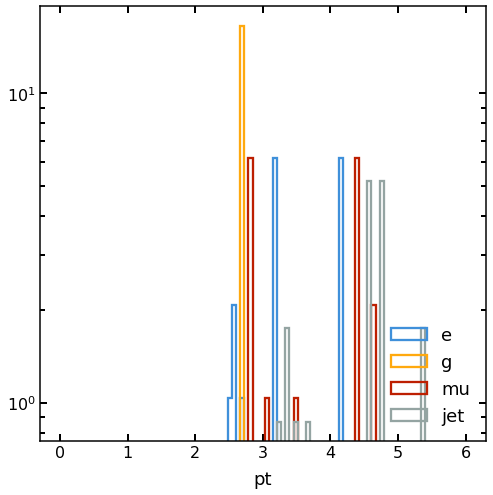

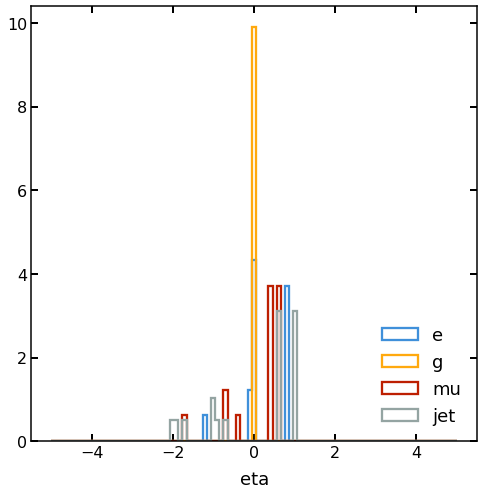

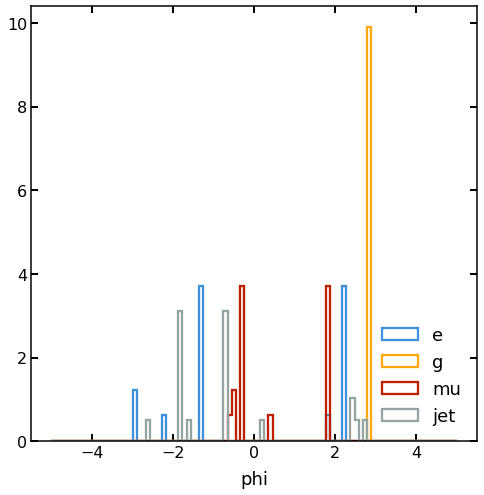

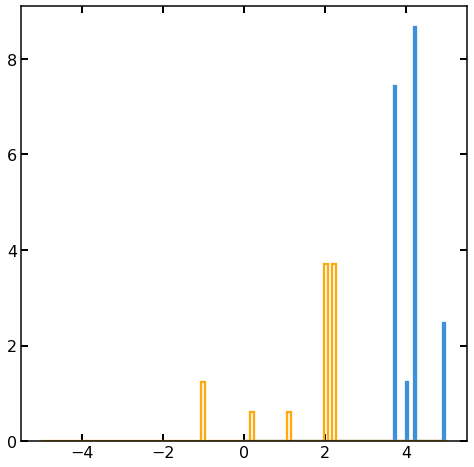

In [355]:
plot_dataset =prepared_dataset_sig[ad_sig_mask][prepared_dataset_sig[ad_sig_mask][:,0,0]==33]
print(plot_dataset.shape)

for i,name in zip([2,3,4],'pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==2:
        bins = np.linspace(0,6,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
   # for pid_name, pid in zip(['b','j','mu','g','e'],[2,3,4,5]):
    for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
        _ = plt.hist(plot_dataset[:,1:,i][np.where(plot_dataset[:,1:,1]==pid)],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
   # plt.semilogy()

    
plt.figure(figsize=(8,8))
_ = plt.hist(plot_dataset[:,0,2],bins=np.linspace(0,5,100),**kwargs)
_ = plt.hist(plot_dataset[:,0,4],bins=np.linspace(-5,5,100),**kwargs)

In [5]:
import json 
import models.models as models
reload(models)
from models.models import load_DenseAE, load_IDEC, load_GraphAE 


load_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/trained_output/graph/'
n_run = 'run_9'
load_dir+=n_run+'/'
#path_model_ae = load_dir+'/best_model_AE.pkl'
path_model_ae = load_dir+'/pretrained_AE_epoch_41.pkl'
path_model_idec = load_dir+'/idec_model_epoch_30.pkl'
path_params = load_dir+'parameters.json'
params_dict = json.loads(json.load(open(path_params)))

model_AE = load_GraphAE(params_dict, device, path_model_ae)
#model = load_IDEC(model_AE,params_dict, device, path_model_idec)

In [466]:
for d in train_loader:
    print(d.x.shape)
    break

torch.Size([1280, 4])


In [6]:
num_clusters_dict = {}

latent_pred = []
true_labels = []
model.eval() 
    
pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
pred_features_met = np.array([model.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
latent_pred = np.array([model.forward(d.to(device))[3].data.cpu().numpy() for i,d in enumerate(train_loader)])
pred_labels = np.array([model.forward(data.to(device))[2].data.cpu().numpy().argmax(1) for i,data in enumerate(train_loader)]) #argmax(1) ##index (cluster nubmber) of the cluster with the highest probability q.
true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
#reshape 
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
pred_labels = np.reshape(pred_labels,pred_labels.shape[0]*pred_labels.shape[1])
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])

acc, nmi, ari,reassignment  = model.validateOnCompleteTestData(true_labels,pred_labels)

print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
#idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
#num_clusters_dict[num_cluster] = {}
#num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
#num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])


IndexError: index 6 is out of bounds for axis 0 with size 6

In [7]:
latent_pred_sig = []
model.eval() 
    
latent_pred_sig = np.array([model.forward(d.to(device))[3].data.cpu().numpy() for i,d in enumerate(train_loader_sig)])
pred_labels_sig = np.array([model.forward(data.to(device))[2].data.cpu().numpy().argmax(1) for i,data in enumerate(train_loader_sig)]) #argmax(1) ##index (cluster nubmber) of the cluster with the highest probability q.
true_labels_sig = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader_sig)])

#reshape 
latent_pred_sig = np.reshape(latent_pred_sig,(latent_pred_sig.shape[0]*latent_pred_sig.shape[1],latent_pred_sig.shape[2]))
pred_labels_sig = np.reshape(pred_labels_sig,pred_labels_sig.shape[0]*pred_labels_sig.shape[1])
true_labels_sig = np.reshape(true_labels_sig,true_labels_sig.shape[0]*true_labels_sig.shape[1])


In [6]:
model_AE = model_AE.eval() 

pred_features = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
pred_features_met = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader)]) 
latent_pred = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(train_loader)])
true_labels = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader)])
#reshape 
latent_pred = np.reshape(latent_pred,(latent_pred.shape[0]*latent_pred.shape[1],latent_pred.shape[2]))
true_labels = np.reshape(true_labels,true_labels.shape[0]*true_labels.shape[1])


pred_features_sig = np.array([model_AE.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(train_loader_sig)])
pred_features_met_sig = np.array([model_AE.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(train_loader_sig)]) 
latent_pred_sig = np.array([model_AE.forward(d.to(device))[2].data.cpu().numpy() for i,d in enumerate(train_loader_sig)])
true_labels_sig = np.array([data.y.cpu().numpy() for i,data in enumerate(train_loader_sig)])

#reshape 
latent_pred_sig = np.reshape(latent_pred_sig,(latent_pred_sig.shape[0]*latent_pred_sig.shape[1],latent_pred_sig.shape[2]))
true_labels_sig = np.reshape(true_labels_sig,true_labels_sig.shape[0]*true_labels_sig.shape[1])

In [109]:
latent_space_h5 = np.concatenate([latent_pred,latent_pred_sig],axis=0)
true_lab_h5 = np.concatenate([np.expand_dims(true_labels,axis=1),np.expand_dims(true_labels_sig,axis=1)],axis=0)

#print(true_lab_h5.shape,latent_space_h5.shape)
#b = np.concatenate([np.expand_dims(true_labels,axis=1),latent_pred],axis=-1)
#s = np.concatenate([np.expand_dims(true_labels_sig,axis=1),latent_pred_sig],axis=-1)
#np.concatenate([b,s],axis=0).shape

file_name_h5 = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/clustering/trained_output/graph/run_9/saved_files/'
file_name_h5+='latent_AE_'+n_run+'_'+path_model_ae.split('/')[-1].replace('.pkl','')+'.h5'

with h5py.File(file_name_h5, 'w') as handle:
    handle.create_dataset('latent_space', data=latent_space_h5)
    handle.create_dataset('true_labels', data=true_lab_h5)
    

In [441]:
pred_features_small.shape

(824, 1280, 4)

In [448]:
#t = file_dataset[:int(1e3),:,2:]
#t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

#t = np.vstack(emb_input)

t = prepared_dataset[:int(1e4),1:,1:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])
t_met = prepared_dataset[:,0:1,[2,4]]
t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])


num_classes = 5


pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:num_classes]),axis=-1),axis=-1)
pred_features_small = np.concatenate([pr_f,pred_features[:,:,num_classes:]],axis=-1)

pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])


pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

    

In [492]:
def prepare_final_output_features(pred_features,pred_features_met,num_classes):
    pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:num_classes]),axis=-1),axis=-1)
    pred_features_small = np.concatenate([pr_f,pred_features[:,:,num_classes:]],axis=-1)
    pred_features_merged_batch = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])
    
    
    s0 = pred_features_small.shape[0]
    s1 = pred_features_small.shape[1]
    s2 = pred_features_small.shape[2]
    pred_features_per_batch = pred_features_small.reshape((s0,batch_size,int(s1/batch_size),s2))
    pred_features_per_batch = pred_features_per_batch.reshape((int(s0*batch_size),int(s1/batch_size),s2))                                                              
                                                      
    pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

    return pred_features_merged_batch, pred_features_per_batch, pred_met
    

def prepare_final_input_features(prepared_dataset):
    len_drop_last = batch_size*(len(prepared_dataset)//batch_size)
    t = prepared_dataset[:len_drop_last,1:,1:]
    t_met = prepared_dataset[:len_drop_last,0:1,[2,4]]
    t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
    return t, t_met
        
          
pred_features_2, pred_features_per_batch, pred_met = prepare_final_output_features(pred_features,pred_features_met,num_classes)

pred_features_2_sig, pred_features_sig_per_batch, pred_met_sig = prepare_final_output_features(pred_features_sig,pred_features_met_sig,num_classes)

input_features, input_met = prepare_final_input_features(prepared_dataset_sig)
input_features_sig, input_met_sig = prepare_final_input_features(prepared_dataset)
                                      
                                                              

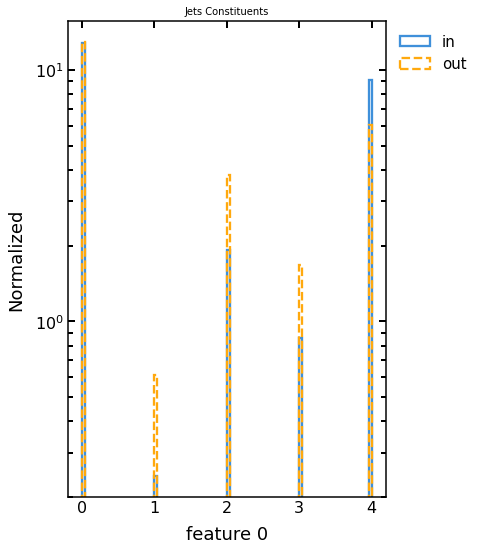

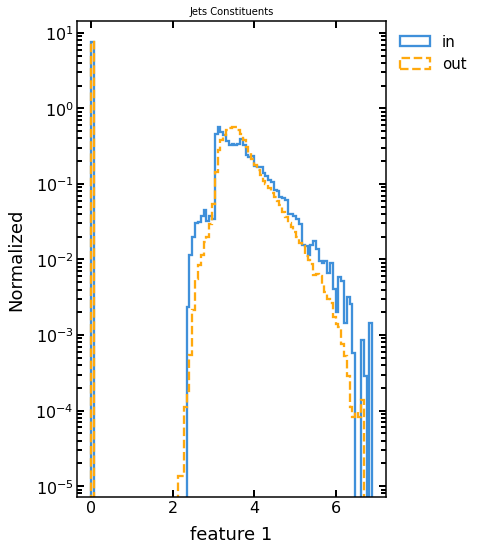

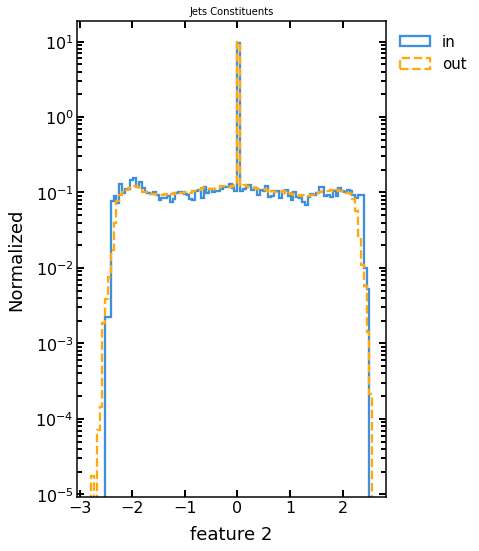

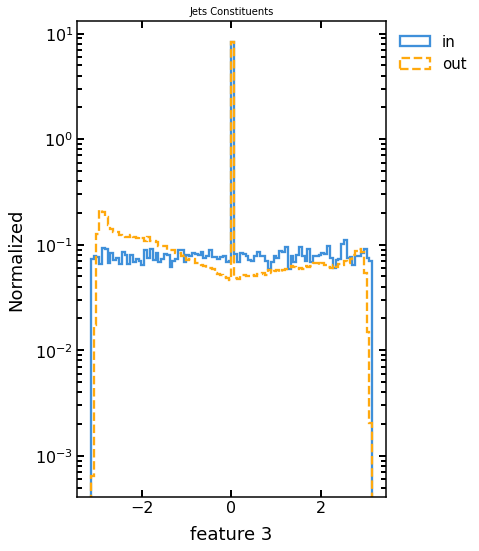

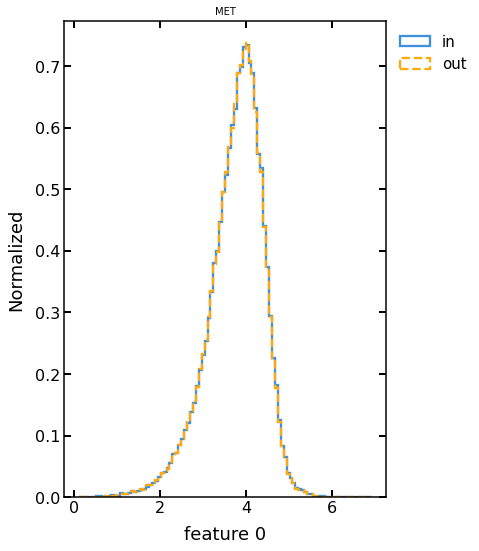

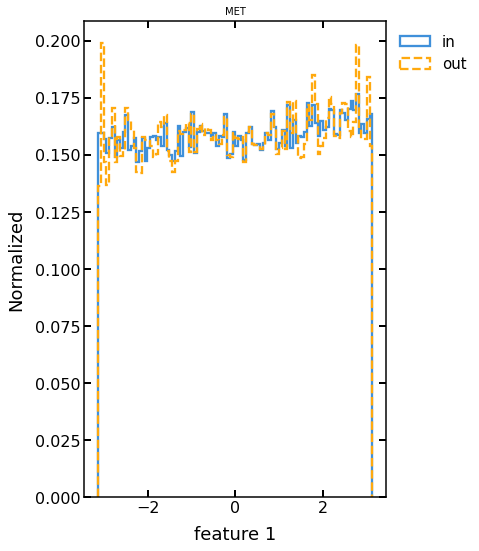

In [452]:
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)


vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([t_met,pred_met], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

In [72]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
import matplotlib.colors as colors
#cmap = plt.cm.rainbow #rainbow
nice_colors = ['#3f90da', '#ffa90e', '#94a4a2', '#832db6', '#a96b59', '#e76300', '#b9ac70', '#717581', '#92dadd','#bd1f01',"#ff00ff"]

def create_color_norm(pred_labels):
    n_col_s = len(np.unique(pred_labels))+1
    cmap_s = (colors.ListedColormap(nice_colors[:n_col_s+1])
        .with_extremes(over='0.25', under='0.75'))
    b_n_s = np.unique(pred_labels)+1
    b_n_s = np.insert(b_n_s,0,0)
    norm_s = colors.BoundaryNorm( b_n_s,cmap_s.N)
    return cmap_s,norm_s,b_n_s

cmap,norm,_ = create_color_norm(true_labels)
cmap_pred,norm_pred,_ = create_color_norm(pred_labels)


NameError: name 'pred_labels' is not defined

(210944,)

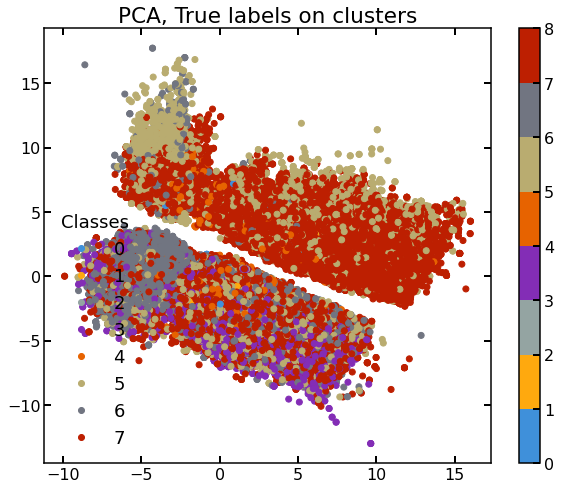

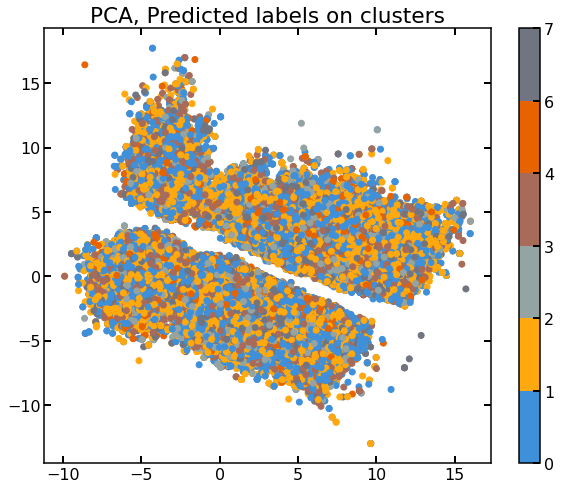

In [76]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

#n_subsample = 5000
#n = int(len(true_labels)/n_subsample)

#skf = StratifiedKFold(n, shuffle = True)
#for _, batch in skf.split(latent_pred, true_labels):
#    break

#principalComponents = TSNE(n_components=2,verbose=1, perplexity=30, n_iter=1000, learning_rate=200
#                          ).fit_transform(latent_pred[batch])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))
pc1 = principalComponents[:,0]#[batch]
pc2 = principalComponents[:,1]#[batch]
principalComponents_sig = pca.transform(np.array(latent_pred_sig))

fig = plt.figure(figsize=(10,8))
#scatter = plt.scatter(pc1,pc2, c=true_labels[batch],cmap=cmap, norm=norm)
scatter = plt.scatter(pc1,pc2, c=true_labels,cmap=cmap, norm=norm)
#scatter = plt.scatter(principalComponents_sig[:4000,0],principalComponents_sig[:4000,1],c=true_labels_sig[:4000],alpha=1.)

plt.title('PCA, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

#ax.add_artist(legend1)

fig = plt.figure(figsize=(10,8))
#plt.scatter(pc1,pc2, c=np.array(predicted_reassigned)[batch],cmap=cmap, norm=norm)
#plt.scatter(pc1,pc2, c=np.array(pred_labels)[batch],cmap=cmap_pred, norm=norm_pred)
plt.scatter(pc1,pc2, c=np.array(pred_labels),cmap=cmap_pred, norm=norm_pred)
#plt.scatter(principalComponents_sig[:4000,0],principalComponents_sig[:4000,1],c='r',alpha=1.)

plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()

In [15]:
#_ = plt.hist2d(principalComponents_sig[:1000,0],principalComponents_sig[:1000,1], bins=50,cmap='Blues')


In [48]:
predicted_classes_dict = {}
for cl in np.unique(pred_labels):
    predicted_classes_dict[cl] = {}
    tot_evt_in_cluster = pred_labels[pred_labels==cl].shape[0]
    true_classes, counts = np.unique(true_labels[np.where(pred_labels==cl)],return_counts=True)
    predicted_classes_dict[cl]['main_class'] = [0,-5]
    for i_t, true_cl in enumerate(true_classes):
        predicted_classes_dict[cl][true_cl] = round(counts[i_t]/tot_evt_in_cluster,4)
        if  predicted_classes_dict[cl][true_cl]>predicted_classes_dict[cl]['main_class'][1]:
            predicted_classes_dict[cl]['main_class'][1] = predicted_classes_dict[cl][true_cl]
            predicted_classes_dict[cl]['main_class'][0] = true_cl
            
            
            
true_classes_dict = {}
for cl in np.unique(true_labels):
    true_classes_dict[cl] = {}
    tot_evt_in_cluster = true_labels[true_labels==cl].shape[0]
    pred_classes, counts = np.unique(pred_labels[np.where(true_labels==cl)],return_counts=True)
    true_classes_dict[cl]['main_class'] = [0,-5]
    for i_t, pred_cl in enumerate(pred_classes):
        true_classes_dict[cl][pred_cl] = round(counts[i_t]/tot_evt_in_cluster,4)
        if  true_classes_dict[cl][pred_cl]>true_classes_dict[cl]['main_class'][1]:
            true_classes_dict[cl]['main_class'][1] = true_classes_dict[cl][pred_cl]
            true_classes_dict[cl]['main_class'][0] = pred_cl

In [49]:
true_classes_dict

{0: {'main_class': [0, 0.3154],
  0: 0.3154,
  1: 0.2962,
  2: 0.0962,
  3: 0.1808,
  5: 0.0423,
  6: 0.0692},
 1: {'main_class': [0, 0.3778],
  0: 0.3778,
  1: 0.3333,
  2: 0.0556,
  3: 0.1,
  5: 0.0444,
  6: 0.0889},
 2: {'main_class': [1, 0.381],
  0: 0.2143,
  1: 0.381,
  2: 0.0952,
  3: 0.1667,
  5: 0.0238,
  6: 0.119},
 3: {'main_class': [1, 0.336],
  0: 0.3089,
  1: 0.336,
  2: 0.08,
  3: 0.138,
  5: 0.0441,
  6: 0.093},
 4: {'main_class': [1, 0.3388],
  0: 0.3198,
  1: 0.3388,
  2: 0.0713,
  3: 0.1437,
  5: 0.0458,
  6: 0.0805},
 5: {'main_class': [1, 0.3387],
  0: 0.3065,
  1: 0.3387,
  2: 0.0806,
  3: 0.1419,
  5: 0.0455,
  6: 0.0869},
 6: {'main_class': [1, 0.3425],
  0: 0.3043,
  1: 0.3425,
  2: 0.0809,
  3: 0.1397,
  5: 0.0452,
  6: 0.0875},
 7: {'main_class': [1, 0.3368],
  0: 0.3122,
  1: 0.3368,
  2: 0.0805,
  3: 0.1409,
  5: 0.0433,
  6: 0.0863}}

In [22]:
predicted_classes_dict

{0: {'main_class': [7, 0.3721],
  0: 0.0012,
  3: 0.1403,
  4: 0.0239,
  5: 0.1663,
  6: 0.2961,
  7: 0.3721},
 1: {'main_class': [7, 0.3754],
  0: 0.0014,
  3: 0.1179,
  4: 0.0263,
  5: 0.1647,
  6: 0.3143,
  7: 0.3754},
 2: {'main_class': [7, 0.7571],
  0: 0.0016,
  4: 0.0273,
  5: 0.2045,
  6: 0.0096,
  7: 0.7571},
 3: {'main_class': [7, 0.3733],
  0: 0.001,
  3: 0.13,
  4: 0.0256,
  5: 0.1646,
  6: 0.3053,
  7: 0.3733},
 5: {'main_class': [7, 0.5458],
  0: 0.0028,
  4: 0.0654,
  5: 0.3175,
  6: 0.0686,
  7: 0.5458},
 6: {'main_class': [7, 0.7987],
  0: 0.0015,
  4: 0.0234,
  5: 0.1707,
  6: 0.0057,
  7: 0.7987}}

In [442]:
s0 = pred_features_small.shape[0]
s1 = pred_features_small.shape[1]
s2 = pred_features_small.shape[2]
pred_reshaped = pred_features_small.reshape((s0,batch_size,int(s1/batch_size),s2))
pred_reshaped = pred_reshaped.reshape((pred_reshaped.shape[0]*pred_reshaped.shape[1],pred_reshaped.shape[2],pred_reshaped.shape[3]) )

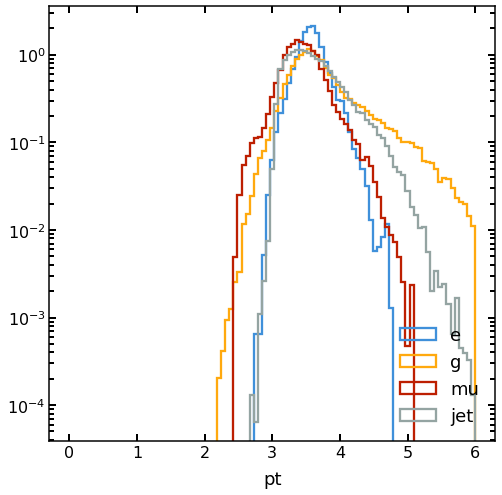

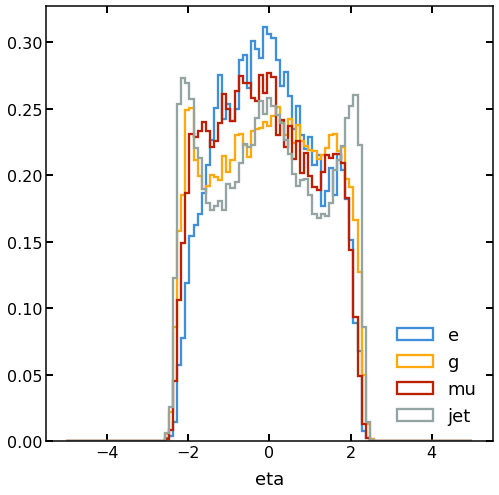

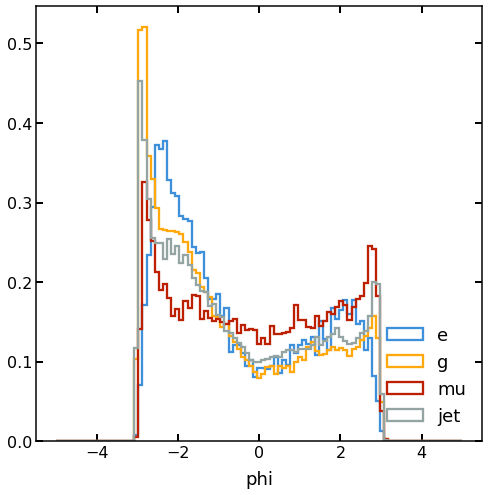

In [443]:
for i,name in zip([1,2,3],'pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==1:
        bins = np.linspace(0,6,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    #for pid_name, pid in zip(['0','b/j','mu','e/g'],[0,1,2,3]):
    #for pid_name, pid in zip(['0','b','j','mu','g','e'],[0,1,2,3,4,5]):
    for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
        mask = pred_reshaped[:,:,0]==pid
        _ = plt.hist(pred_reshaped[:,:,i][mask],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
    #plt.semilogy()

In [493]:
mask = latent_pred[:,0]>-100000 #pred_labels==1
mask_sig = latent_pred_sig[:,0]>-100000 #pred_labels_sig==1

sig_bg_3 = np.concatenate([latent_pred[mask],latent_pred_sig[mask_sig]],axis=0)
#pred_labels_sig_bg_3 = np.concatenate([pred_labels[mask],pred_labels_sig[mask_sig]],axis=0)
true_labels_sig_bg_3 = np.concatenate([true_labels[mask],true_labels_sig[mask_sig]],axis=0)
target = true_labels_sig_bg_3
pred_features_bg_sig = np.concatenate([pred_features_per_batch,pred_features_sig_per_batch],axis=0)
pred_met_bg_sig = np.concatenate([pred_met,pred_met_sig],axis=0)
input_features_bg_sig = np.concatenate([input_features,input_features_sig],axis=0)
input_met_bg_sig = np.concatenate([input_met,input_met_sig],axis=0)

#pred_labels_3 = pred_labels[pred_labels==3]
#latent_pred_3 = latent_pred[pred_labels==3]

In [494]:
print(input_met_bg_sig.shape,input_features_bg_sig.shape)

(230912, 2) (230912, 5, 4)


In [11]:
_ = plt.hist(latent_pred[pred_labels==3][:,1],bins=100,density=1)
_ = plt.hist(latent_pred_sig[pred_labels_sig==3][:,1],bins=100,density=1)


NameError: name 'pred_labels' is not defined

In [60]:
# Initialization and training
n_neurons = 50
m_neurons = 50
if som:
    del som
som = MiniSom(n_neurons, m_neurons, sig_bg_3.shape[1], sigma=1.5, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(sig_bg_3)
som.train(sig_bg_3, int(1e5), verbose=False)  # random training


In [16]:
marker_list = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

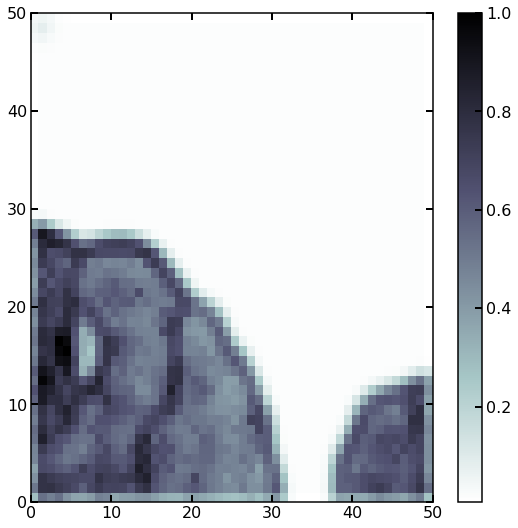

In [61]:

plt.figure(figsize=(9, 9))

distance_map = som.distance_map().T
plt.pcolor(distance_map, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
#for cnt, xx in enumerate(sig_bg_3):
#    w = som.winner(xx)  # getting the winner
#    # palce a marker on the winning position for the sample xx
#    plt.plot(w[0]+.5, w[1]+.5, markerfacecolor='None',   marker=marker_list[np.where(b_n_s==target[cnt]+1)[0][0]],
#             markeredgecolor=nice_colors[np.where(b_n_s==target[cnt]+1)[0][0]-1],
#             markersize=12, markeredgewidth=2)

plt.show()

In [78]:
t_e_sig_only = som.topographic_error(latent_pred_sig,mean=False)
t_e_sig = som.topographic_error(sig_bg_3,mean=False)

[]

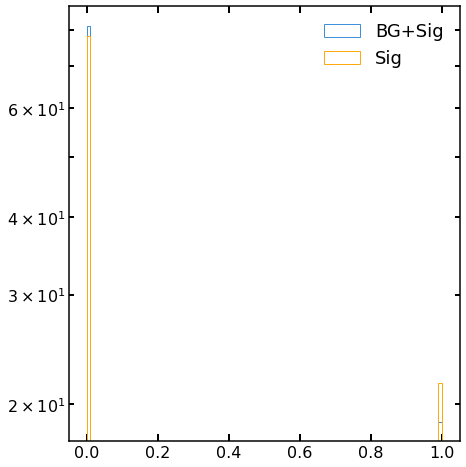

In [79]:
_ = plt.hist(t_e_sig,bins=100,density=True,histtype='step',label='BG+Sig')
_ = plt.hist(t_e_sig_only,bins=100,density=True,histtype='step',label='Sig')
plt.legend(loc='upper right')
plt.semilogy()

In [83]:
mask_ad_t = np.where(t_e_sig>0.5)
lab,count = np.unique(true_labels_sig_bg_3[mask_ad_t],return_counts=True)
for l,c in zip(lab,count):
    print('proc {} : {} '.format(l,round(c/np.sum(count),4)))

proc 0 : 0.0013 
proc 1 : 0.0003 
proc 2 : 0.0001 
proc 3 : 0.0649 
proc 4 : 0.0282 
proc 5 : 0.1542 
proc 6 : 0.253 
proc 7 : 0.3984 
proc 30 : 0.0208 
proc 31 : 0.0268 
proc 32 : 0.0238 
proc 33 : 0.0283 


In [75]:
q_e_sig_only = som.quantization_error(latent_pred_sig, mean=False)
q_e_sig = som.quantization_error(sig_bg_3, mean=False)


[]

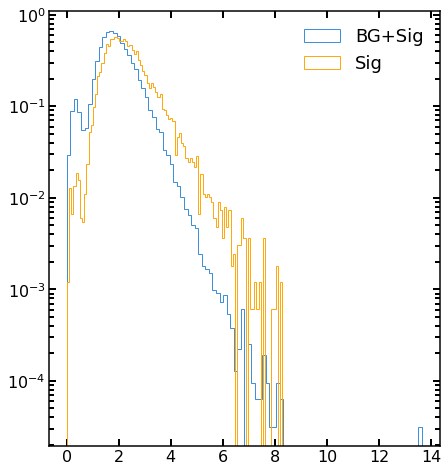

In [76]:
_ = plt.hist(q_e_sig,bins=100,density=True,histtype='step',label='BG+Sig')
_ = plt.hist(q_e_sig_only,bins=100,density=True,histtype='step',label='Sig')
plt.legend(loc='upper right')
plt.semilogy()


In [77]:
mask_ad = np.where(q_e_sig>6)
lab,count = np.unique(true_labels_sig_bg_3[mask_ad],return_counts=True)
for l,c in zip(lab,count):
    print('proc {} : {} '.format(l,round(c/np.sum(count),2)))

proc 3 : 0.03 
proc 5 : 0.06 
proc 6 : 0.04 
proc 7 : 0.08 
proc 30 : 0.72 
proc 31 : 0.03 
proc 32 : 0.01 
proc 33 : 0.03 


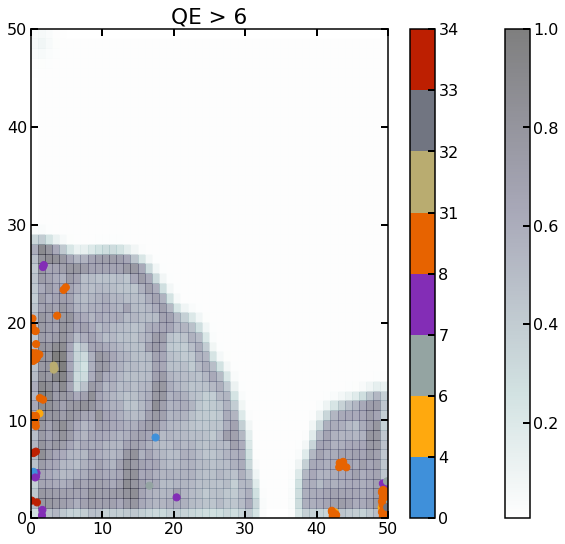

In [96]:
distance_map = som.distance_map().T

w_x_bg, w_y_bg = zip(*[som.winner(d) for d in sig_bg_3[mask_ad]])
w_x_bg = np.array(w_x_bg)
w_y_bg = np.array(w_y_bg)
plt.figure(figsize=(10, 9))
plt.pcolor(distance_map, cmap='bone_r', alpha=.5)
plt.colorbar()

#bins = np.linspace(0,50,51)
#h_bg = plt.hist2d(w_x_bg,w_y_bg,bins=(bins,bins), cmap='bone_r')
cmap_ad,norm_ad,_ = create_color_norm(true_labels_sig_bg_3[mask_ad])

plt.scatter(w_x_bg+0.5+(np.random.rand(np.sum(w_x_bg.shape[0]))-.5)*.8, w_y_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8,s=50,c=np.array(true_labels_sig_bg_3[mask_ad]),cmap=cmap_ad,norm=norm_ad)
plt.title('QE > 6')
cb = plt.colorbar()


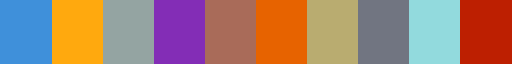

In [88]:
cmap_ad

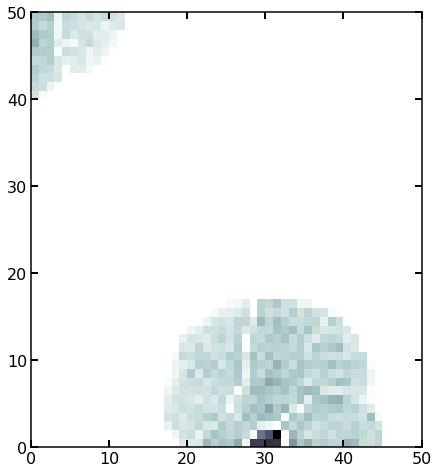

In [117]:
w_x_bg, w_y_bg = zip(*[som.winner(d) for d in latent_pred])
w_x_bg = np.array(w_x_bg)
w_y_bg = np.array(w_y_bg)
bins = np.linspace(0,50,51)
h_bg = plt.hist2d(w_x_bg,w_y_bg,bins=(bins,bins), cmap='bone_r')

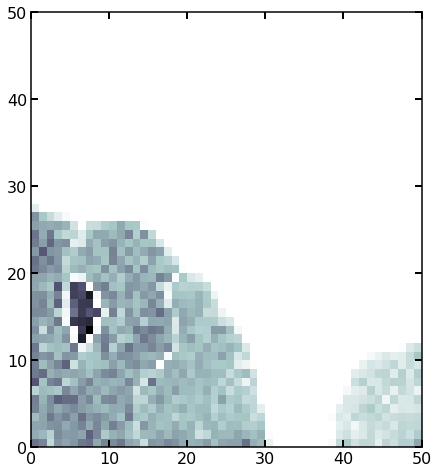

In [93]:
w_x, w_y = zip(*[som.winner(d) for d in sig_bg_3])
w_x = np.array(w_x)
w_y = np.array(w_y)
bins = np.linspace(0,50,51)
h_bg_sig = plt.hist2d(w_x,w_y,bins=(bins,bins), cmap='bone_r')

In [119]:
w_x

array([ 2, 32, 32, ..., 42, 25, 27])

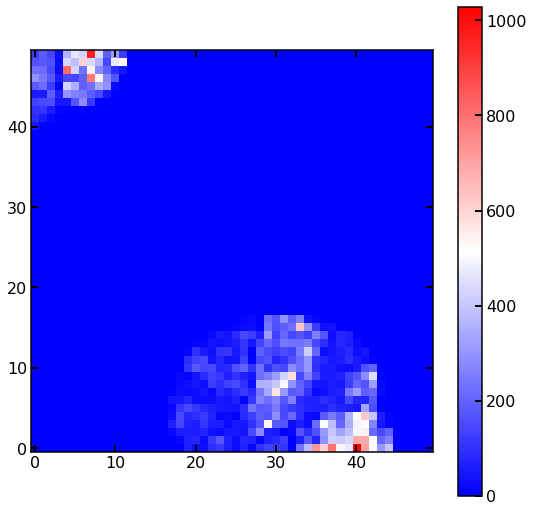

In [120]:
plt.figure(figsize=(9, 9))
plt.imshow((h_bg_sig[0]-h_bg[0]).T,cmap='bwr',origin='lower')
plt.colorbar()

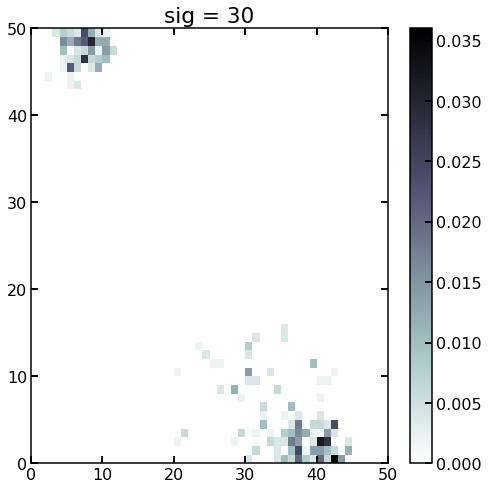

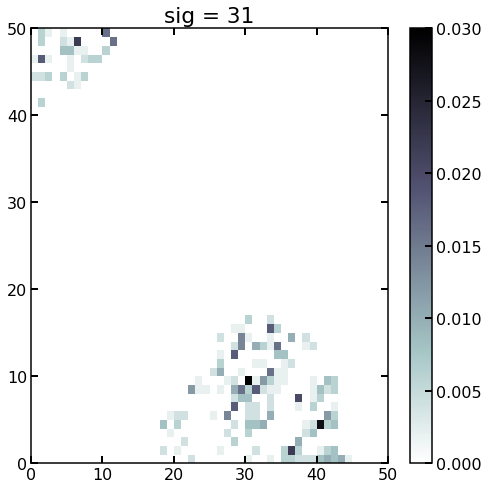

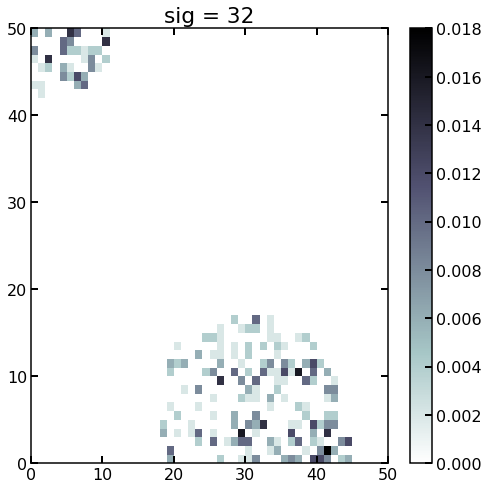

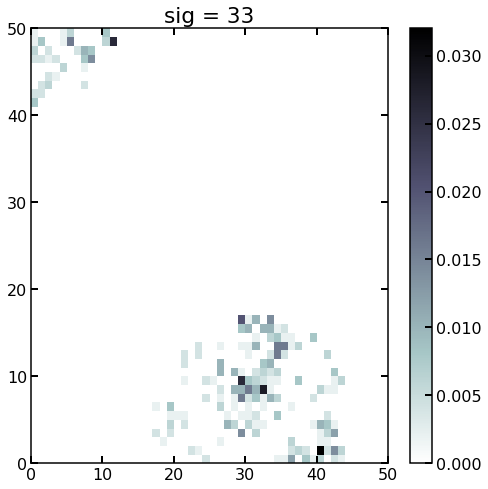

In [131]:
for label in np.unique(true_labels_sig):
    plt.figure(figsize=(8,8))
    w_x, w_y = zip(*[som.winner(d) for d in latent_pred_sig[true_labels_sig==label]])
    w_x = np.array(w_x)[:500]
    w_y = np.array(w_y)[:500]
    bins = np.linspace(0,50,51)
    h_sig = plt.hist2d(w_x,w_y,bins=(bins,bins), cmap='bone_r',density=True)#,cmin=0.008
    plt.title('sig = {}'.format(label))
    plt.colorbar()


In [415]:
h_sig[0][47][0]
#print(w_x.shape)
#print(ad_sig_mask[0].shape)

103.0

In [416]:
ad_sig_mask = np.where((w_x==47) & (w_y==0))
ad_sig_mask_bg = np.where((w_x_bg==47) & (w_y_bg==0))

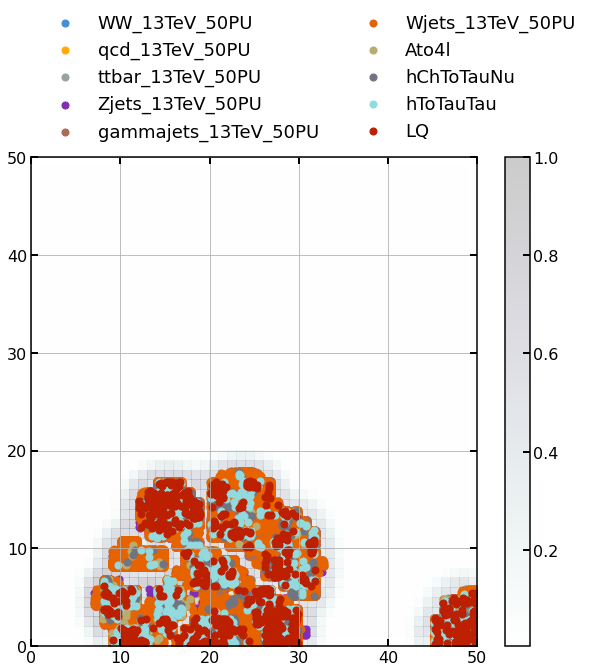

In [47]:
w_x, w_y = zip(*[som.winner(d) for d in sig_bg_3])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(distance_map, cmap='bone_r', alpha=.2)
plt.colorbar()

cmap_s,norm_s,b_n_s = create_color_norm(true_labels_sig_bg_3)


for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=nice_colors[np.where(b_n_s==c+1)[0][0]-1],label=process_name_dict[c])
plt.legend(loc='lower left', bbox_to_anchor=(0., 1), ncol=2)
plt.grid()
#plt.savefig('resulting_images/som_seed.png')
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 214784 but corresponding boolean dimension is 210944

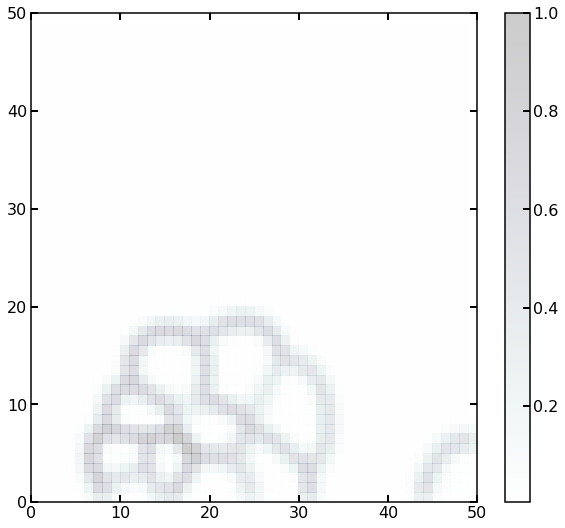

In [46]:
w_x, w_y = zip(*[som.winner(d) for d in sig_bg_3])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(distance_map, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(true_labels):
    idx_target = true_labels==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=nice_colors[np.where(b_n_s==c+1)[0][0]-1],label=process_name_dict[c])
plt.legend(loc='lower left', bbox_to_anchor=(0., 1), ncol=2)
plt.grid()
#plt.savefig('resulting_images/som_seed.png')
plt.show()

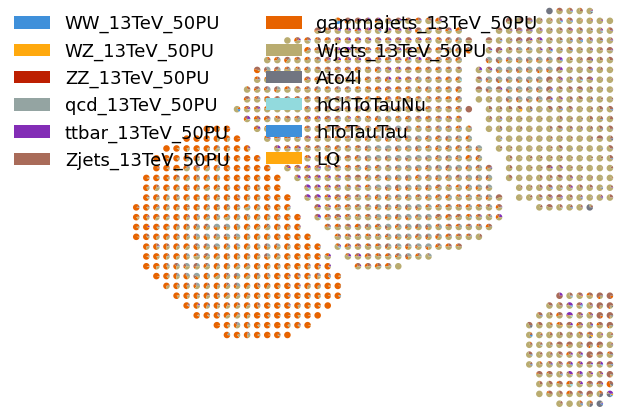

In [364]:
import matplotlib.gridspec as gridspec


labels_map = som.labels_map(sig_bg_3, [process_name_dict[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in process_name_dict.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, process_name_dict.values(), bbox_to_anchor=(1,2), ncol=2)
#plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

In [367]:
 patches[-1]

In [90]:
def create_color_norm(pred_labels):
    n_col_s = len(np.unique(pred_labels))+1
    cmap_s = (colors.ListedColormap(nice_colors[:n_col_s+1])
        .with_extremes(over='0.25', under='0.75'))
    b_n_s = np.unique(pred_labels)+1
    b_n_s = np.insert(b_n_s,0,0)
    norm_s = colors.BoundaryNorm( b_n_s,cmap_s.N)
    return cmap_s,norm_s,b_n_s

#cmap_s,norm_s,b_n_s = create_color_norm(true_labels_sig_bg_3)

In [101]:
b_n_s

NameError: name 'b_n_s' is not defined

(array([0, 4, 5, 6, 7], dtype=int32), array([  15,  288, 1477,  317, 2403]))

In [11]:
nice_colors

['#3f90da',
 '#ffa90e',
 '#94a4a2',
 '#832db6',
 '#a96b59',
 '#e76300',
 '#b9ac70',
 '#717581',
 '#92dadd',
 '#bd1f01']

In [85]:
from sklearn.neighbors import NearestNeighbors


In [90]:
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('../../som-anomaly-detector/')))
from anomaly_detection import AnomalyDetection


In [109]:
anomaly_detector = AnomalyDetection((n_neurons, m_neurons), sig_bg_3.shape[1], 8, 0.001, 2, 0.001, 100, 5)
       # learning_rate,
       # learning_decay=0.1,
       # initial_radius=1,
       # radius_decay=0.1,
       # min_number_per_bmu=1,
       # number_of_neighbors=3,

In [110]:
N_ITER_TO_FIT = 5000

anomaly_detector.fit(sig_bg_3, N_ITER_TO_FIT)
anomaly_metrics = anomaly_detector.evaluate(sig_bg_3)

/eos/home-n/nchernya/MLHEP/AnomalyDetection/som-anomaly-detector/som_anomaly_detector/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


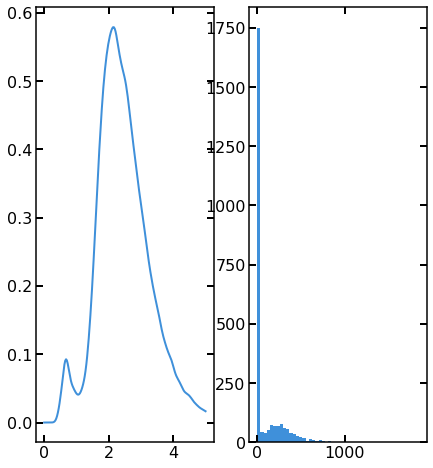

In [111]:
from scipy.stats import gaussian_kde

plt.subplot(121)
density = gaussian_kde(anomaly_metrics)
xs = np.linspace(0, 5, 200)
plt.plot(xs, density(xs))

plt.subplot(122)
_ = plt.hist(anomaly_detector.bmu_counts,bins=50)


[]

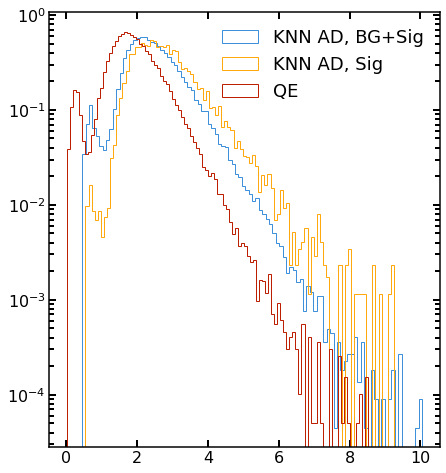

In [113]:
anomaly_metrics_sig_only = anomaly_detector.evaluate(latent_pred_sig)

_ = plt.hist(anomaly_metrics,bins=100,histtype='step',density=True,label='KNN AD, BG+Sig')
_ = plt.hist(anomaly_metrics_sig_only,bins=100,histtype='step',density=True,label='KNN AD, Sig')
_ = plt.hist(q_e_sig,bins=100,density=True,histtype='step',label='QE')
plt.legend(loc='upper right')
plt.semilogy()


In [116]:
anomaly_detector.get_bmu([sig_bg_3[1]])

(17, 14)

In [86]:
mask_knn = np.where(anomaly_metrics>7)

w_x_bg, w_y_bg = zip(*[anomaly_detector.get_bmu(d) for d in sig_bg_3[mask_knn]])
w_x_bg = np.array(w_x_bg)
w_y_bg = np.array(w_y_bg)
plt.figure(figsize=(10, 9))
#plt.pcolor(distance_map, cmap='bone_r', alpha=.3)
#plt.colorbar()

#bins = np.linspace(0,50,51)
#h_bg = plt.hist2d(w_x_bg,w_y_bg,bins=(bins,bins), cmap='bone_r')
cmap_ad,norm_ad,_ = create_color_norm(true_labels_sig_bg_3[mask_knn])

plt.scatter(w_x_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8, w_y_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8,s=50,c=np.array(true_labels_sig_bg_3[mask_knn]),cmap=cmap_ad,norm=norm_ad)
plt.title('KNN dist > 7')
cb = plt.colorbar()

NameError: name 'anomaly_metrics' is not defined

In [45]:
from sklearn.neighbors import NearestNeighbors
import minisom


class AnomalyDetectionMiniSom(MiniSom):
    """"
    This class uses provides an specific implementation of Kohonnen Som for anomaly detection.
    """

    def __init__(
        self,
        x, y, 
        input_len, 
        sigma=1.0, 
        learning_rate=0.5,
        decay_function=minisom.asymptotic_decay,
        neighborhood_function='gaussian', topology='rectangular',
        activation_distance='euclidean', random_seed=None,
        min_number_per_bmu=1,
        number_of_neighbors=3,
    ):
        super(AnomalyDetectionMiniSom, self).__init__(
            x, y, input_len, sigma=1.0, learning_rate=0.5,
                 decay_function=minisom.asymptotic_decay,
                 neighborhood_function='gaussian', topology='rectangular',
                 activation_distance='euclidean', random_seed=None
        )
     
    
        self.shape = (x,y)
        self.input_len = input_len
        self.minNumberPerBmu = min_number_per_bmu
        self.numberOfNeighbors = number_of_neighbors
        self.grid = np.random.rand(*(self.shape + (self.input_len,))) * 2 - 1

    def reset(self):
        """
        This function resets the grid for a new estimation to take place
        :return: Nothing
        """
        self.grid = np.random.rand(*(self.shape + (self.input_len,))) * 2 - 1

        return

    def get_bmu_counts(self, training_data):
        """
        This functions maps a training set to the fitted network and evaluates for each
        node in the SOM the number of evaluations mapped to that node. This gives counts per BMU.
        :param training_data: numpy array of training data
        :return: An array of the same shape as the network with the best matching units.
        """
        bmu_counts = np.zeros(shape=self.shape)
        for observation in training_data:
            bmu = self.winner(observation)
            bmu_counts[bmu] += 1
        return bmu_counts

    def fit(self, training_data, num_iterations):
        """
        This function fits the anomaly detection model to some training data.
        It removes nodes that are too sparse by the minNumberPerBmu threshold.
        :param training_data: numpy array of training data
        :param num_iterations: number of iterations allowed for training
        :return: A vector of allowed nodes
        """
        #self.reset()
        super(AnomalyDetectionMiniSom, self).pca_weights_init(training_data)
        super(AnomalyDetectionMiniSom, self).train(training_data, num_iterations,verbose=False)
                
        bmu_counts = self.get_bmu_counts(training_data)
        self.bmu_counts = bmu_counts.flatten()
        self.allowed_nodes = self._weights[bmu_counts >= self.minNumberPerBmu]
        return self.allowed_nodes

    def evaluate(self, evaluationData):
        """
        This function maps the evaluation data to the previously fitted network. It calculates the
        anomaly measure based on the distance between the observation and the K-NN nodes of this
        observation.
        :param evaluationData: Numpy array of the data to be evaluated
        :return: 1D-array with for each observation an anomaly measure
        """
        try:
            self.allowed_nodes
            assert self.allowed_nodes.shape[0] > 1
        except NameError:
            raise Exception(
                "Make sure the method fit is called before evaluating data."
            )
        except AssertionError:
            raise Exception(
                "There are no nodes satisfying the minimum criterium, algorithm cannot proceed."
            )
        else:
            classifier = NearestNeighbors(n_neighbors=self.numberOfNeighbors)
            classifier.fit(self.allowed_nodes)
            dist, _ = classifier.kneighbors(evaluationData)
        return dist.mean(axis=1)

In [392]:
# Initialization and training
import math
n_neurons = 50
m_neurons = 50
#if som_AD:
#    del som_AD
#min_number_per_bmu = int(math.sqrt(len(sig_bg_3)))
min_number_per_bmu = 152
som_AD = AnomalyDetectionMiniSom(n_neurons, m_neurons, sig_bg_3.shape[1], sigma=1.5, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=0,        
                min_number_per_bmu=min_number_per_bmu,
            number_of_neighbors=9)


In [393]:
_ = som_AD.fit(sig_bg_3, int(1e5))  

In [394]:
anomaly_metrics_som = som_AD.evaluate(sig_bg_3)
anomaly_metrics_som_sig_only = som_AD.evaluate(latent_pred_sig)

q_e_sig_ad = som_AD.quantization_error(sig_bg_3,mean=False)
q_e_sig_only_ad = som_AD.quantization_error(latent_pred_sig,mean=False)

[]

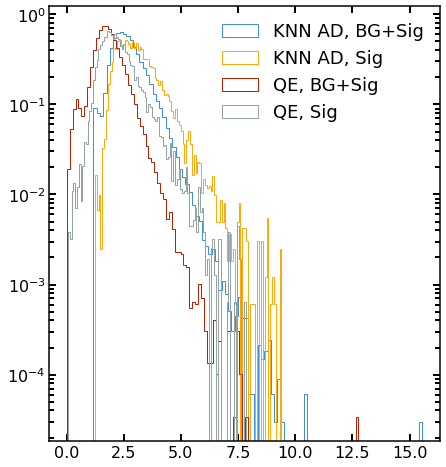

In [395]:

_ = plt.hist(anomaly_metrics_som,bins=100,histtype='step',density=True,label='KNN AD, BG+Sig')
_ = plt.hist(anomaly_metrics_som_sig_only,bins=100,histtype='step',density=True,label='KNN AD, Sig')
_ = plt.hist(q_e_sig_ad,bins=100,density=True,histtype='step',label='QE, BG+Sig')
_ = plt.hist(q_e_sig_only_ad,bins=100,density=True,histtype='step',label='QE, Sig')
plt.legend(loc='upper right')
plt.semilogy()

plt.legend(loc='upper right')
plt.semilogy()


In [416]:
mask_knn

(array([ 29885,  50492,  52355,  66416,  68340,  69045,  72270,  85967,
         86511,  93529,  96213, 109682, 135927, 144072, 150918, 152031,
        156279, 158070, 160580, 164749, 168199, 172893, 187150, 190302,
        202500, 203379, 211006, 211016, 211048, 211113, 211180, 211183,
        211261, 211303, 211391, 211424, 211433, 211556, 211558, 211616,
        211625, 211646, 211775, 211801, 211848, 211849, 211985, 212010,
        212101, 212208, 212305, 212456, 212541, 212722, 212731, 213053,
        213075, 213421, 213426, 213437, 213471, 213679, 213686, 213797,
        213813, 213830, 213837, 213857, 213967, 214114, 214152, 214153,
        214221, 214249, 214302, 214321, 214384, 214415, 214595, 214596,
        214686, 214854, 214865, 215065, 215529, 215615, 215636, 215686,
        215768, 215784, 215805, 215810, 215819, 215841, 215869, 215914,
        222936, 227384, 229017]),)

proc 3 : 0.02, evts : 2
proc 5 : 0.07, evts : 7
proc 6 : 0.11, evts : 11
proc 7 : 0.06, evts : 6
proc 30 : 0.71, evts : 70
proc 32 : 0.01, evts : 1
proc 33 : 0.02, evts : 2


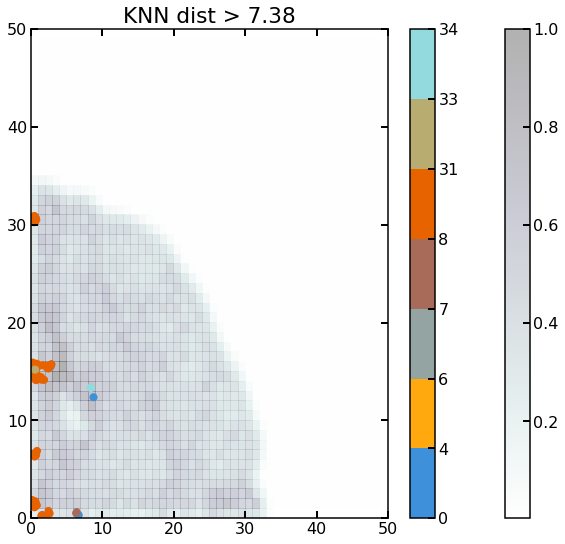

In [411]:
retrain_num = 100
theshold = np.sort(anomaly_metrics_som)[::-1][:retrain_num][-1]

distance_map = som_AD.distance_map().T

mask_knn = np.where(anomaly_metrics_som>theshold)
lab,count = np.unique(true_labels_sig_bg_3[mask_knn],return_counts=True)
for l,c in zip(lab,count):
    print('proc {} : {}, evts : {}'.format(l,round(c/np.sum(count),2),c))
    
w_x_bg, w_y_bg = zip(*[som_AD.winner(d) for d in sig_bg_3[mask_knn]])
w_x_bg = np.array(w_x_bg)
w_y_bg = np.array(w_y_bg)
plt.figure(figsize=(10, 9))
plt.pcolor(distance_map, cmap='bone_r', alpha=.3)
plt.colorbar()

#bins = np.linspace(0,50,51)
#h_bg = plt.hist2d(w_x_bg,w_y_bg,bins=(bins,bins), cmap='bone_r')
cmap_ad,norm_ad,_ = create_color_norm(true_labels_sig_bg_3[mask_knn])

plt.scatter(w_x_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8, w_y_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8,s=50,c=np.array(true_labels_sig_bg_3[mask_knn]),cmap=cmap_ad,norm=norm_ad)
plt.title('KNN dist > {}'.format(round(theshold,2)))
cb = plt.colorbar()


proc 3 : 0.02, evts : 2
proc 5 : 0.13, evts : 13
proc 6 : 0.04, evts : 4
proc 7 : 0.04, evts : 4
proc 30 : 0.72, evts : 71
proc 32 : 0.01, evts : 1
proc 33 : 0.04, evts : 4


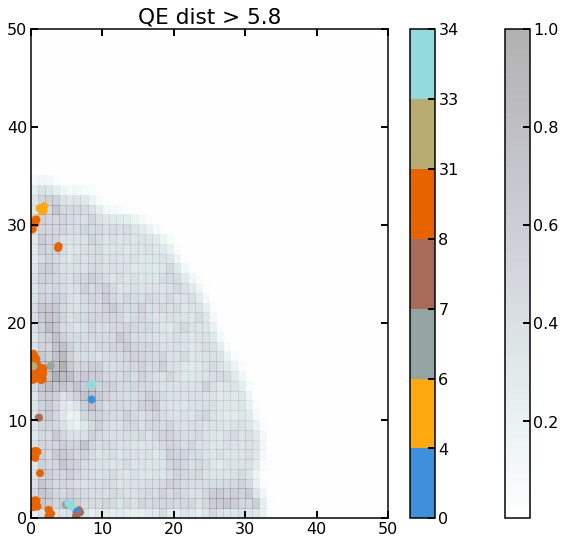

In [410]:
theshold = np.sort(q_e_sig_ad)[::-1][:retrain_num][-1]

mask_knn = np.where(q_e_sig_ad>theshold)
lab,count = np.unique(true_labels_sig_bg_3[mask_knn],return_counts=True)
for l,c in zip(lab,count):
    print('proc {} : {}, evts : {}'.format(l,round(c/np.sum(count),2),c))
    
w_x_bg, w_y_bg = zip(*[som_AD.winner(d) for d in sig_bg_3[mask_knn]])
w_x_bg = np.array(w_x_bg)
w_y_bg = np.array(w_y_bg)
plt.figure(figsize=(10, 9))
plt.pcolor(distance_map, cmap='bone_r', alpha=.3)
plt.colorbar()

#bins = np.linspace(0,50,51)
#h_bg = plt.hist2d(w_x_bg,w_y_bg,bins=(bins,bins), cmap='bone_r')
cmap_ad,norm_ad,_ = create_color_norm(true_labels_sig_bg_3[mask_knn])

plt.scatter(w_x_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8, w_y_bg+0.5+(np.random.rand(np.sum(w_y_bg.shape[0]))-.5)*.8,s=50,c=np.array(true_labels_sig_bg_3[mask_knn]),cmap=cmap_ad,norm=norm_ad)
plt.title('QE dist > {}'.format(round(theshold,2)))
cb = plt.colorbar()


In [398]:
som_AD.allowed_nodes.shape

(703, 10)

In [399]:
bmu_counts = som_AD.get_bmu_counts(sig_bg_3)
bmu_counts_flat = bmu_counts.flatten()
#allowed_nodes = som_AD._weights[bmu_counts_flat >= 50]

In [389]:
bmu_counts

array([[288., 435., 241., ...,   0.,   0.,   0.],
       [265., 273., 314., ...,   0.,   0.,   0.],
       [357., 427.,  95., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [350]:
#To have an idea of which neurons of the map are activated more often 
#we can create another pseudocolor plot that reflects the activation frequencies:
act = som_AD.activation_response(sig_bg_3)


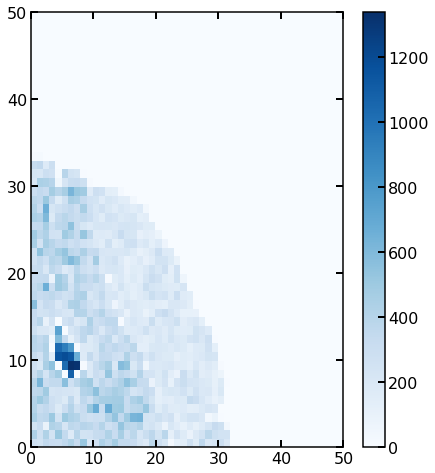

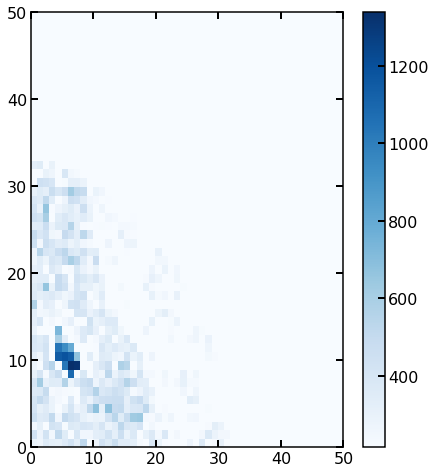

In [363]:
plt.subplot(111)
plt.pcolor(act.T, cmap='Blues',vmin=0) 
plt.colorbar()
plt.show()

plt.subplot(111)
plt.pcolor(act.T, cmap='Blues',vmin=216) 
plt.colorbar()
plt.show()

In [352]:
retain_num = int(0.3*len(act.flatten()))
print(retain_num)
np.sort(act.T.flatten())[::-1][retain_num]

750


126.0

In [369]:
cum_x = np.sort(act.T.flatten())[::-1]
cum_y = np.cumsum(cum_x/np.sum(cum_x))


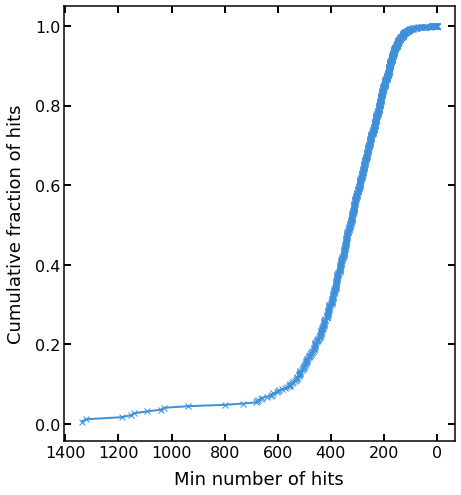

In [370]:
plt.plot(cum_x, cum_y,marker='x')
plt.gca().invert_xaxis()
plt.xlabel('Min number of hits')
plt.ylabel('Cumulative fraction of hits')
plt.show()

In [307]:
thresholds = [0.8,0.9,0.95]
for t in thresholds:
    print('t = {} -> hits = {}'.format(t,np.max(cum_x[cum_y>t])))

t = 0.8 -> hits = 216.0
t = 0.9 -> hits = 177.0
t = 0.95 -> hits = 152.0


In [296]:
cum_y

array([0.00579442, 0.01151954, 0.01666436, ..., 1.        , 1.        ,
       1.        ])

In [380]:
(len(cum_x)-np.sum(cum_x<min_number_per_bmu))/len(cum_x)

0.2812

In [377]:
np.sum(cum_x)

230912.0

In [595]:
#mask_cluster = np.where((w_y_bg>10)&(w_y_bg<20)&(w_x_bg <7))[0]
#mask_cluster = np.where((w_y_bg>25)&(w_x_bg <7))[0]
#mask_cluster = np.where((w_y_bg>10)&(w_y_bg<20)&(w_x_bg >5))[0]
mask_cluster = np.where((w_y_bg>=0)&(w_y_bg<5)&(w_x_bg <6))[0]

sig_bg_3[mask_knn][mask_cluster]

#sig_bg_3 = np.concatenate([latent_pred[mask],latent_pred_sig[mask_sig]],axis=0)
#pred_labels_sig_bg_3 = np.concatenate([pred_labels[mask],pred_labels_sig[mask_sig]],axis=0)
true_labels_sig_bg_3[mask_knn][mask_cluster]

array([ 7, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30], dtype=int32)

Text(0.5, 0, 'MET phi')

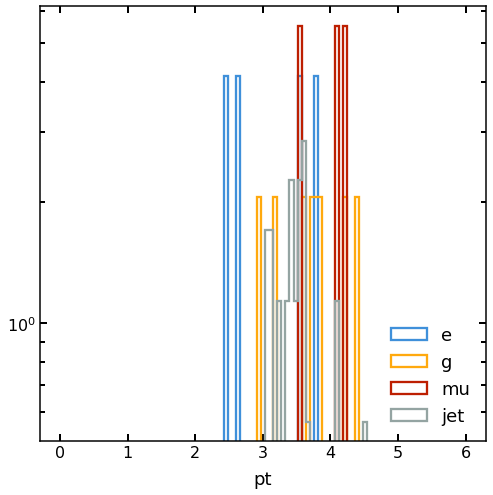

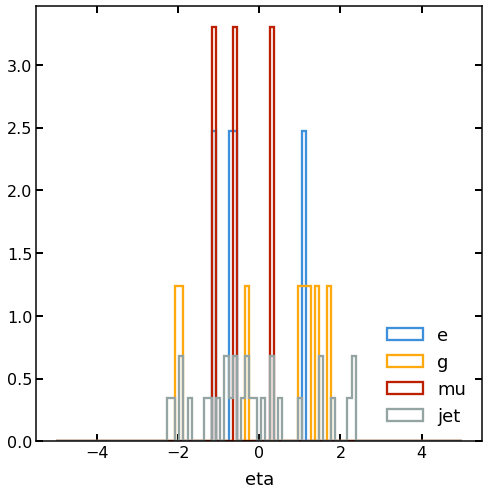

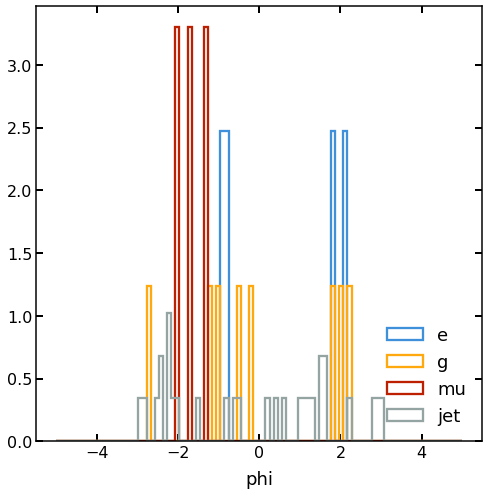

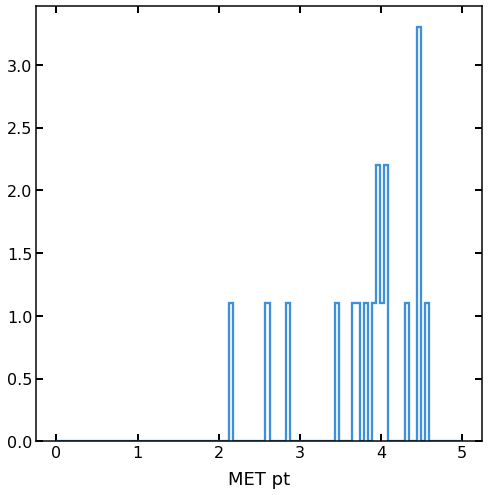

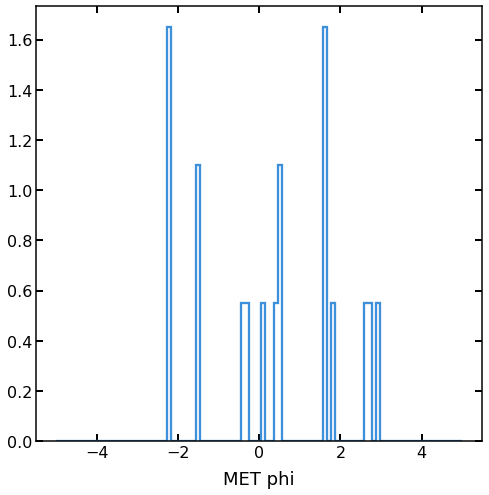

In [596]:
input_features_bg_sig_ad = input_features_bg_sig[mask_knn][mask_cluster]

for i,name in zip([1,2,3],'pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,100)
    if i==1:
        bins = np.linspace(0,6,100)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
   # for pid_name, pid in zip(['b','j','mu','g','e'],[2,3,4,5]):
    for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
        _ = plt.hist(input_features_bg_sig_ad[:,0:,i][np.where(input_features_bg_sig_ad[:,0:,0]==pid)],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')
   # plt.semilogy()

    
input_met_bg_sig_ad = input_met_bg_sig[mask_knn][mask_cluster]
plt.figure(figsize=(8,8))
_ = plt.hist(input_met_bg_sig_ad[:,0],bins=np.linspace(0,5,100),**kwargs)
plt.xlabel('MET pt')
plt.figure(figsize=(8,8))
_ = plt.hist(input_met_bg_sig_ad[:,1],bins=np.linspace(-5,5,100),**kwargs)
plt.xlabel('MET phi')

In [597]:
n_objects = {}
for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
    n_pid_per_evt = np.sum(input_features_bg_sig_ad[:,0:,0]==pid,axis=1)
    n_objects[pid_name] = n_pid_per_evt
    n_pid_per_evt_mean = np.mean(n_pid_per_evt)
    n_pid_per_evt_median = np.median(n_pid_per_evt)
    #n_pid_frac = n_pid_per_evt/np.sum(input_features_bg_sig_ad[:,0:,0]>-1,axis=1)
    print('PID : ',pid)
    print(n_pid_per_evt_mean,n_pid_per_evt_median)

PID :  1
0.2222222222222222 0.0
PID :  2
0.4444444444444444 0.0
PID :  3
0.16666666666666666 0.0
PID :  4
1.6111111111111112 1.0


Text(0.5, 1.0, 'Anomalous events')

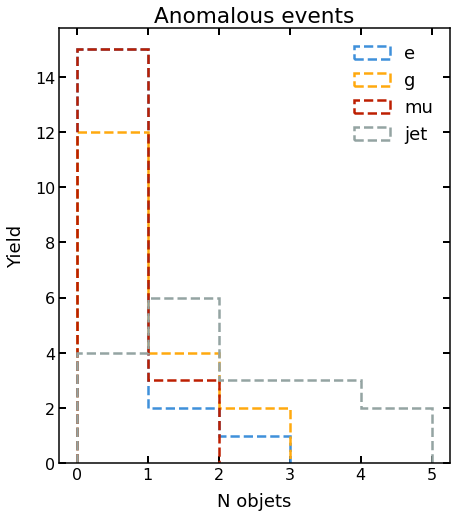

In [598]:
kwargs={'linewidth':2.5, 'fill':False, 'density':False,'histtype':'step','linestyle':'dashed'}
for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
    bins = np.linspace(0,len(np.unique(n_objects[pid_name])),len(np.unique(n_objects[pid_name]))+1)
    _ = plt.hist(n_objects[pid_name],bins=bins,label=pid_name,**kwargs)
plt.legend()
plt.xlabel('N objets')
plt.ylabel('Yield')
plt.title('Anomalous events')


Text(0.5, 1.0, 'Anomalous events from A->4l only')

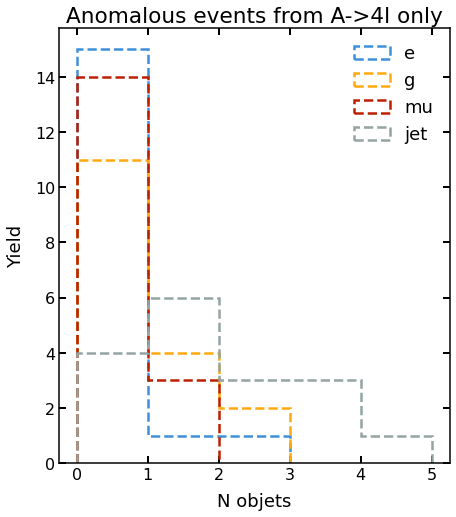

In [599]:
input_labels_bg_sig_ad = true_labels_sig_bg_3[mask_knn][mask_cluster]

for pid_name, pid in zip(['e','g','mu','jet'],[1,2,3,4]):
    bins = np.linspace(0,len(np.unique(n_objects[pid_name])),len(np.unique(n_objects[pid_name]))+1)
    _ = plt.hist(n_objects[pid_name][np.where(input_labels_bg_sig_ad==30)],bins=bins,label=pid_name,**kwargs)

plt.legend()
plt.legend()
plt.xlabel('N objets')
plt.ylabel('Yield')
plt.title('Anomalous events from A->4l only')
